### **Tugas Besar Matkul Jaringan Syaraf Tiruan**
#### Anggota:
1. Indradi Rahmatullah
2. Piki Yakup Pranoto
3. Rizal Muhammad Nur Abidin

#### Dataset: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
#### Metode: Convolution Neural Network (**CNN**)

#### **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Prepare Kaggle API & Download Dataset**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset

100% 534M/534M [00:18<00:00, 33.7MB/s]
100% 534M/534M [00:18<00:00, 29.8MB/s]


In [ ]:
!unzip /content/vegetable-image-dataset.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/Vegetable Images/train/Radish/0001.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0002.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0003.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0004.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0005.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0006.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0007.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0008.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0009.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0010.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0011.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0012.jpg  
  inflating: /content/dataset/Vegetable Images/train/Radish/0013.jpg  
  inflating: /content/data

In [ ]:
import pandas as pd
import os

#### Menyalin dan mempersiapkan folder dataset dari penyimpanan sementara Google Colab ke direktori Google Drive

In [11]:
!cd /content/dataset
!cp -r dataset/Vegetable '/content/drive/MyDrive/Project JST'

In [13]:
%cd /content/drive/MyDrive/Project JST

/content/drive/MyDrive/Project JST


In [24]:
#Directory path
train_dir = "/content/drive/MyDrive/Project JST/train"
valid_dir = "/content/drive/MyDrive/Project JST/validation"

#### **Import library**

In [63]:
import numpy as np 
import seaborn as sb
import matplotlib.pyplot as plt
import cv2
import os
import re
import random
import pandas as pd
from scipy import ndimage as ndi

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#### **Dataset Exploration**

##### Load each image from different classand make it tensor

In [26]:
# load salah satu citra dari masing masing class yang ada, dan menjadikannya sebagai sebuah tensor
explor_data = []
labels = []
testing_path = '/content/drive/MyDrive/Project JST/test' 
for label in os.listdir(testing_path): #Loop each class
  path = testing_path+'/'+label
  img_paths = os.listdir(path)
  random.shuffle(img_paths)
  img_path = path+'/'+img_paths[0]
  img = plt.imread(img_path) #Load image
  img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR )
  explor_data.append(img) #Memasukkan citra kedalam list
  labels.append(label) #Memasukkan encoded label kedala list

explor_data = np.array(explor_data)
explor_data.shape

(15, 224, 224, 3)

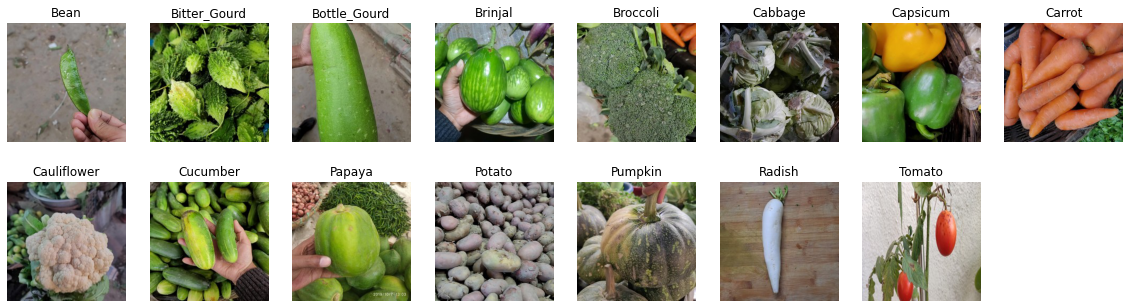

In [27]:
plt.figure(figsize=(20,20))
for i in range(15):
  plt.subplot (7,8,i+1)
  plt.title(labels[i])
  plt.axis('off')
  plt.imshow( explor_data[i] )

#### **Dataset Augmentation**

In [28]:
datagen = ImageDataGenerator(
    rescale = 1./255,       # dilakukan proses rescaling warna dari 0-255, dinormalisasi ke float 0-1
    rotation_range = 20,    # dilakukan rotasi acak sejauh dengan rentang terbesar 20 derajat   
    zoom_range = 0.2,       # diperbesar dengan rentang 0.2 kali ukuran asli citra
    shear_range = 0.2,      # dipangkas 0.2 ukuran asli citra
    width_shift_range = 0,  # tidak memberikan rentang pergeseran lebar
    height_shift_range = 0, # tidak memberikan rentang pergeseran tinggi
    vertical_flip = False,  # tidak melakukan pembalikan vertikal
    fill_mode = 'nearest')  # memberikan fill_mode dengan mode 'nearest'

#### **Load Dataset using datagenerator**

In [33]:
train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),     # target ukuran citra untuk dijadikan bentuk tensor
        batch_size=32,
        class_mode='categorical')   # mode categorical karena dataset terdiri dari kelas yang berbeda

validation_generator = datagen.flow_from_directory(
        valid_dir,
        target_size=(224, 224),
        batch_size=32,
        shuffle = False)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [34]:
# menyimpan indeks kelas yang akan digunakan sebagai map untuk testing
train_generator.class_indices

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

#### **Make Callback Function**

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback

#folder tujuan model akan disimpan
modelFolder = 'result/'

# checkpoint ini digunakan untuk menyimpan model training ketika loss mencapai titik minimum
checkpointLoss = ModelCheckpoint(f"{modelFolder}bestLoss.hdf5", 
                            monitor='loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint ini digunakan untuk menyimpan model training ketika loss untuk validation mencapai titik minimum
checkpointValLoss = ModelCheckpoint(f"{modelFolder}bestValLoss.hdf5", 
                            monitor='val_loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# early stop ini membuat model berhenti melakukan proses training ketika tidak ada perubahan setelah beberapa epoch
# di sini terdapat nilai patience sebesar 10 yang berarti apabila tidak ada perubahan nilai loss ataupun val_loss sebanyak 10 epoch berturut-turut,
# maka proses training akan dihentikan saat itu juga.
earlyStopVal = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# callback ini hanya berjalan apabila nilai akurasi lebih besar dari 95% dan loss lebih kecil dari 0.1% 
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('loss')<0.001):
            print("\nAkurasi telah mencapai > 95%! dan loss < 0.001")
            self.model.stop_training = True

callbacks = myCallback()

#### **Make Sequential Model**

In [36]:
model = models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(15, activation='sigmoid')
])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [37]:
# cell ini meng-compile model yang sudah dibuat dan memberikan loss function serta optimizer yang dibutuhkan
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

#### **Training Model with Train and Validation Data**

In [38]:
# cell ini melakukan training model dengan data train dan validation
# memberikan jumlah maksimum epoch yang dilakukan dan memberikan callback function
history = model.fit(
                train_generator,
                validation_data=validation_generator,
                epochs=60,
                callbacks=[callbacks,
                           checkpointValLoss, 
                           earlyStopVal
                           ],
                )

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: 1.5674 - accuracy: 0.4739
Epoch 1: val_loss improved from inf to 0.84106, saving model to result/bestValLoss.hdf5
469/469 [==============================] - 246s 503ms/step - loss: 1.5674 - accuracy: 0.4739 - val_loss: 0.8411 - val_accuracy: 0.7287
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7853
Epoch 2: val_loss improved from 0.84106 to 0.42508, saving model to result/bestValLoss.hdf5
469/469 [==============================] - 235s 501ms/step - loss: 0.6698 - accuracy: 0.7853 - val_loss: 0.4251 - val_accuracy: 0.8660
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: 0.4086 - accuracy: 0.8752
Epoch 3: val_loss improved from 0.42508 to 0.24003, saving model to result/bestValLoss.hdf5
469/469 [==============================] - 231s 492ms/step - loss: 0.4086 - accuracy: 0.8752 - val_loss: 0.2400 - val_accuracy: 0.9260
Epoch 4/60
469/469 [===============

In [39]:
# menyimpan model terakhir sesuai dengan pemberhentian callback yang terjadi
model.save(f'{modelFolder}lastModel')

#### **Plotting the difference of loss and accuracy** [1]

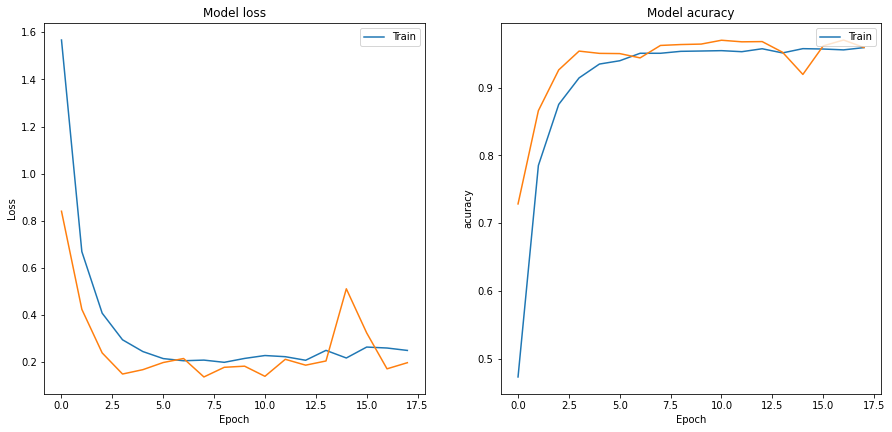

In [52]:
# plotting untuk menampilkan grafik perubahan loss pada proses training
# grafik yang bergerak turun menandakan kondisi yang baik
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# plotting untuk menampilkan grafik perubahan akurasi pada proses training
# grafik yang bergerak naik menandakan kondisi yang baik
plt.subplot(2,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acuracy')
plt.ylabel('acuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

#### **Save Comparison History**

In [44]:
import pandas as pd
df = pd.DataFrame()
df["accuracy"] = history.history["accuracy"]
df["val_accuracy"] = history.history['val_accuracy']
df["loss"] = history.history['loss']
df["val_loss"] = history.history["val_loss"]
df.to_csv(f"{modelFolder}history.csv")

In [45]:
# memuat history untuk analisa
historyBasic = pd.read_csv('result/history.csv')

In [46]:
# melihat berapa nomor epoch terakhir
print(historyBasic.shape)

(18, 5)


In [47]:
historyBasic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18 non-null     int64  
 1   accuracy      18 non-null     float64
 2   val_accuracy  18 non-null     float64
 3   loss          18 non-null     float64
 4   val_loss      18 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 848.0 bytes


In [48]:
basicEpochs = [i for i in range(18)]

#### **Plotting the difference of loss and accuracy** [2]

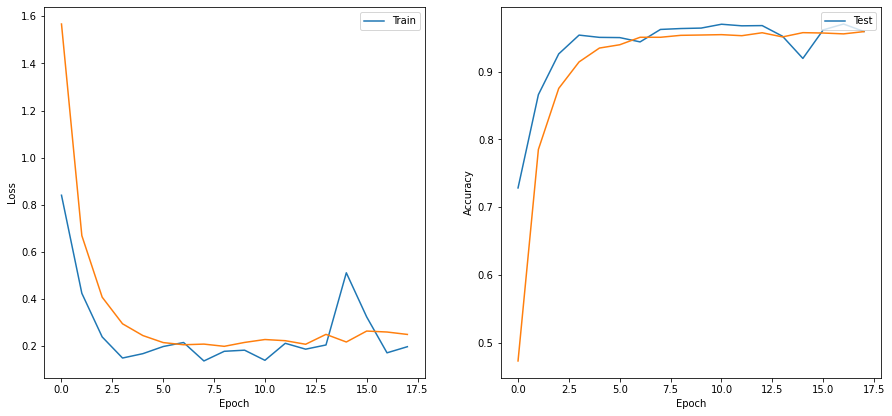

In [49]:
# plotting untuk menampilkan grafik perubahan loss dan akurasi pada proses training
# grafik loss yang bergerak turun menandakan kondisi yang baik
# grafik akurasi yang bergerak naik menandakan kondisi yang baik
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.plot(historyBasic['val_loss'])
plt.plot(historyBasic['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper right')

plt.subplot(2,2,2)
plt.plot(historyBasic['val_accuracy'])
plt.plot(historyBasic['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Test'], loc='upper right')

#### **Labeling for testing process**

In [53]:
labels_map = {'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

#### **Modified all dataset to tensor**

In [54]:
testing_data = []
labels = []
testing_path = '/content/drive/MyDrive/Project JST/test' 
for label in os.listdir(testing_path):
  path = testing_path+'/'+label
  for filename in os.listdir(path):
    img_path = path+'/'+filename
    img = plt.imread(img_path)
    img = cv2.resize(img, (224,224), interpolation = cv2.INTER_LINEAR )
    testing_data.append(img)
    labels.append(labels_map[label])

testing_data = np.array(testing_data)/255

In [55]:
print(testing_data.shape)

(3000, 224, 224, 3)


In [56]:
# cell ini memuat model yang sudah dibuat sebelumnya
basicModel = models.load_model('result/bestValLoss.hdf5')

In [57]:
# cell ini melakukan prediksi tes tensor
testBasic = [np.argmax(i) for i in basicModel.predict(testing_data)]

94/94 [==============================] - 2s 21ms/step


#### **Accuracy Results (97%)**

In [58]:
print(classification_report(labels, testBasic))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       200
           1       1.00      0.94      0.97       200
           2       0.99      0.98      0.99       200
           3       0.94      0.97      0.96       200
           4       0.93      0.99      0.96       200
           5       0.93      0.98      0.96       200
           6       1.00      0.96      0.98       200
           7       0.99      1.00      0.99       200
           8       0.95      0.97      0.96       200
           9       0.98      0.98      0.98       200
          10       0.98      0.95      0.96       200
          11       0.99      1.00      0.99       200
          12       0.99      0.94      0.96       200
          13       0.99      0.99      0.99       200
          14       0.96      0.94      0.95       200

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97   

#### **Confussion Matrix Plotting**

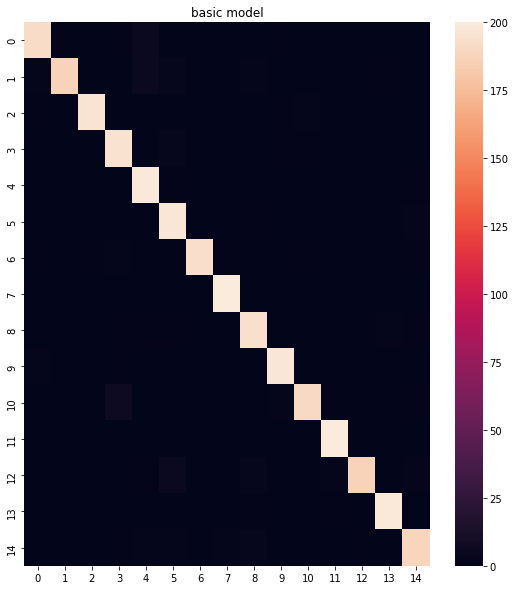

In [60]:
# cell ini melakukan plotting dan menampilkan confussion matriks 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('basic model')
sb.heatmap(confusion_matrix(labels, testBasic))

### **Conclusion**


1. Algoritma CNN adalah algoritma yang cukup baik untuk digunakan dalam pembuatan model jaringan syaraf tiruan untuk melakukan pengenalan objek
2. Model yang sudah dibuat memiliki akurasi 90%, persentase ini sudah sangat baik untuk diimplementasikan
3. Penggunaan callback function memberikan waktu pembuatan model yang lebih efisien. 

